# 迁移学习和微调

## Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

D:\ProgramData\Anaconda3\envs\deep\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\ProgramData\Anaconda3\envs\deep\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\ProgramData\Anaconda3\envs\deep\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\ProgramData\Anaconda3\envs\deep\lib\site-packages\tensorflow\python\frame

## Introduction

**迁移学习** 包含对一个问题学习的特征，以及利用他们解决一个新的、类似的问题。例如，具有学会识别浣熊可能对启动一个用来识别的模型很有用。
迁移学习通常用于数据集数据量太少的任务从头开始训练全尺寸模型。
在深度学习的背景下，迁移学习最常见的体现是遵循工作流:
1. 从先前训练过的模型中提取图层。
2. 冻结它们，以避免在以后的训练中破坏它们所包含的任何信息。
3. 在冻结层的顶部添加一些新的、可训练的层。他们将学习如何将旧的特性转化为对新数据集的预测。
4. 在数据集中训练新层。
最后一个可选步骤是**微调**，它包括解冻上面获得的整个模型（或其中的一部分），然后以非常低的学习率在新数据上重新训练它。通过逐步地将预训练的特性适应新数据，这可能会实现有意义的改进。
首先，我们将详细介绍Keras“trainable”API，它是大多数迁移学习和微调工作流的基础。
然后，我们将演示典型的工作流，方法是在ImageNet数据集上预先训练一个模型，然后在Kaggle“猫对狗”分类数据集上对其进行再训练。

## 冻结层：了解`trainable`属性
层和模型有三个权重属性：
- `weights` 是层的所有权重变量的列表。
- `trainable_weights` 是要更新（通过梯度下降）以将训练过程中的损失最小化的列表。
- `non_trainable_weights` 是那些不需要训练的对象的名单。
 通常，在前向传递过程中，模型会对其进行更新。
 
**示例：`Dense` 层有2个可训练权重（内核和偏移）**

In [2]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
weights: 2
trainable_weights: 2
non_trainable_weights: 0


一般来说，所有重量都是可训练的重量。唯一具有不可训练权重的内置层是`BatchNormalization`层。它使用不可训练的权值来跟踪训练期间输入的均值和方差。
要了解如何在自己的自定义层中使用不可训练的权重，请参见
[从头开始编写新图层指南](https://keras.io/guides/making_new_layers_and_models_via_subclassing/).

**示例：`BatchNormalization`层有2个可训练权重和2个不可训练权重**

In [3]:
layer = keras.layers.BatchNormalization()
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 4
trainable_weights: 2
non_trainable_weights: 2


Layers&models还具有布尔属性`trainable`。它的值可以更改。

设置`layer.trainable`为 `False` 将层的所有权重从可训练移动到不可训练。这被称为“冻结”层：冻结层的状态在训练期间不会更新（无论是在使用`fit()`进行训练时，还是在使用任何依赖于`trainable_weights`应用渐变更新的自定义循环进行训练时）。

**示例: setting `trainable` to `False`**

In [4]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights
layer.trainable = False  # Freeze the layer

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 0
non_trainable_weights: 2


当可训练权重变为不可训练时，其值在训练期间不再更新。

In [5]:
# Make a model with 2 layers
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
model = keras.Sequential([keras.Input(shape=(3, )), layer1, layer2])

# Freeze the first layer
layer1.trainable = False

# 保留layer1的权重副本以供以后参考
initial_layer1_weights_values = layer1.get_weights()

# Train the model
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

# 检查第1层的重量在训练期间没有变化
final_layer1_weights_values = layer1.get_weights()
np.testing.assert_allclose(initial_layer1_weights_values[0],
                           final_layer1_weights_values[0])
np.testing.assert_allclose(initial_layer1_weights_values[1],
                           final_layer1_weights_values[1])

2/2 [==============================] - 0s 194ms/sample - loss: 0.0516


不要混淆`layer.trainable` 在`layer.__call__()`中具有参数`training`的属性（它控制层是在推理模式还是训练模式下运行前向传递）。有关详细信息，请参阅
[Keras FAQ](
  https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute).

## `rainable`属性的递归设置
如果在模型或具有子层的任何层上设置`trainable = False` ，则所有子层也将变为不可训练。

**Example:**

In [6]:
inner_model = keras.Sequential([
    keras.Input(shape=(3, )),
    keras.layers.Dense(3, activation="relu"),
    keras.layers.Dense(3, activation="relu"),
])

model = keras.Sequential([
    keras.Input(shape=(3, )),
    inner_model,
    keras.layers.Dense(3, activation="sigmoid"),
])

model.trainable = False  # 冻结外部模型

assert inner_model.trainable == False  # “model”中的所有层现在都被冻结了
assert inner_model.layers[0].trainable == False  # `trainable` 以递归方式传播

## 典型的迁移学习工作流
这就引出了如何在Keras中实现典型的迁移学习工作流：
1. 实例化一个基本模型并将预先训练好的权重加载到其中。
2. 通过设置`trainable = False`冻结基础模型中的所有图层 .
3. 在基础模型的一个（或多个）层的输出之上创建一个新模型。
4. 在新数据集上训练新模型。
请注意，另一种更轻量级的工作流也可以是：
1. 实例化一个基本模型并将预先训练好的权重加载到其中。
2. 在其中运行新的数据集，并记录基础模型中一个（或多个）层的输出。这叫做**特征提取**。
3. 将该输出用作新的更小模型的输入数据。
第二个工作流的一个主要优点是，您只对数据运行一次基本模型，而不是每个培训周期运行一次。所以它更快更便宜。
不过，第二个工作流的一个问题是，它不允许您在培训期间动态修改新模型的输入数据，例如，在进行数据扩充时，这是必需的。迁移学习通常用于新数据集的数据太少而无法从头开始训练完整模型的任务，在这种情况下，数据扩充非常重要。所以在接下来的内容中，我们将关注第一个工作流。
Here's what the first workflow looks like in Keras:
首先，用预先训练的权重实例化一个基本模型。
```python
base_model = keras.applications.Xception(
    weights='imagenet',  # 在ImageNet上预先训练的负重。
    input_shape=(150, 150, 3),
    include_top=False)  # 不要在顶部包含ImageNet分类器。
```
Then, freeze the base model.
```python
base_model.trainable = False
```
Create a new model on top.
```python
inputs = keras.Input(shape=(150, 150, 3))
# 我们通过传递“training=False”来确保base_模型在推理模式下运行。这对于微调非常重要，您将在几段中了解到这一点。
x = base_model(inputs, training=False)
# 转换`base_model.output_shape[1:]`向量 
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
```
Train the model on new data.
```python
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
model.fit(new_dataset, epochs=20, callbacks=..., validation_data=...)
```

## 微调
一旦您的模型在新数据上收敛，您可以尝试解冻全部或部分基础模型，并以非常低的学习率端到端地重新训练整个模型。

这是一个可选的最后一步，可能会给您带来增量改进。这也可能导致快速过度适应——记住这一点。

只有在冻结层的模型被训练为收敛后，才执行这一步是至关重要的。如果您将随机初始化的可训练层与包含预训练特征的可训练层混合，则随机初始化的层将在训练期间导致非常大的梯度更新，这将破坏您的预训练

特征。

在这一阶段使用非常低的学习率也是非常重要的，因为您在一个通常非常小的数据集上训练的模型比第一轮训练中要大得多。

因此，如果应用较大的权重更新，则很快会有过度拟合的风险。在这里，您只需要以增量方式重新适应预训练权重。

如何对整个基础模型进行微调：
```python
# 解冻 base model
base_model.trainable = True
# 在您对任何内层的“trainable”属性进行任何更改后，重新编译模型是很重要的，这样您的更改就会被考虑在内
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
# Train end-to-end. Be careful to stop before you overfit!
model.fit(new_dataset, epochs=10, callbacks=..., validation_data=...)
```
**关于 `compile()` and `trainable`**
在模型上调用`compile()`意味着“冻结”该模型的行为。这意味着编译模型时的 `trainable`属性值应在该模型的整个生命周期中保留，直到再次调用`compile` 。因此，如果您更改任何 `trainable` 值，请确保在模型上再次调用`compile()` ，以便将您的更改考虑在内。
**关于`BatchNormalization`层的重要说明**
许多图像模型包含`BatchNormalization`层。这层是每一个可以想象到的特殊情况。这里有几件事要记住。
- `BatchNormalization`包含2个不可训练的权重，它们在训练期间更新。这些是跟踪输入均值和方差的变量。
- 当您设置`bn_layer.trainable = False`，则`BatchNormalization` 层将在推理模式下运行，并且不会更新其均值和方差统计信息。一般情况下，其他层不是这样，例如
[weight trainability & inference/training modes are two orthogonal concepts](
  https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute).
But the two are tied in the case of the `BatchNormalization` layer.
- 当解冻包含`BatchNormalization`层的模型以进行微调时，应在调用基模型时传递`training=False`，使`BatchNormalization`层保持在推理模式下。
否则，应用于不可训练权重的更新将突然破坏模型所学的内容。
您将在本指南末尾的端到端示例中看到这种模式的实际应用。

## 迁移学习和使用定制训练循环进行微调
如果不是使用`fit()`，而是使用自己的低级培训循环，那么工作流基本上保持不变。你应该小心只考虑清单`model.trainable_weights`应用渐变更新时：
```python
# 创建基础模型
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False)
# 冻结 base model
base_model.trainable = False
# 在顶部创建新模型。
inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam()
# 迭代数据集的批处理。
for inputs, targets in new_dataset:
    # 打开渐变带。
    with tf.GradientTape() as tape:
        # 向前传播。
        predictions = model(inputs)
        # 计算此批次的损失值。
        loss_value = loss_fn(targets, predictions)
    # 得到与可训练重量相关的损失梯度。
    gradients = tape.gradient(loss_value, model.trainable_weights)
    #更新模型的权重。
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
```

微调也是如此。

## 一个端到端的例子：对猫和狗的图像分类模型进行微调
 为了巩固这些概念，让我们介绍一个具体的端到端转移学习和微调示例。我们将加载在ImageNet上预先训练过的模型，并将其用于Kaggle“cats vs.dogs”分类数据集。

### 获取数据
首先，让我们使用TFDS获取cats和dogs数据集。如果您有自己的数据集，您可能希望使用该实用程序`tf.keras.preprocessing.image_dataset_from_directory`从磁盘上的一组映像生成类似的带标签的数据集对象，并将其放入类特定的文件夹中。当使用非常小的数据集时，迁移学习是最有用的。为了保持数据集的小，我们将使用40%的原始训练数据（25000幅图像）进行训练，10%用于验证，10%用于测试。

In [16]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # 保留10%用于验证，10%用于测试
    split=[
        tfds.Split.TRAIN.subsplit(tfds.percent[:40]),
        tfds.Split.TRAIN.subsplit(tfds.percent[40:50]),
        tfds.Split.TRAIN.subsplit(tfds.percent[50:60]),],
    as_supervised=True,  # 包括标签
)

print("Number of training samples: " + str(tf.data.experimental.cardinality(train_ds)))
print("Number of validation samples: " +
      str(tf.data.experimental.cardinality(validation_ds)))
print("Number of test samples: " + str(tf.data.experimental.cardinality(test_ds)))

Number of training samples: Tensor("ExperimentalDatasetCardinality_8:0", shape=(), dtype=int64)
Number of validation samples: Tensor("ExperimentalDatasetCardinality_9:0", shape=(), dtype=int64)
Number of test samples: Tensor("ExperimentalDatasetCardinality_10:0", shape=(), dtype=int64)


这是训练数据集中的前9张图片——如你所见，它们的大小都不一样。

TypeError: Image data of dtype object cannot be converted to float

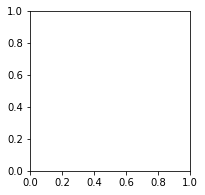

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

我们还可以看到标签1是“狗”，标签0是“猫”。

### 数据标准化
我们的原始图像有各种尺寸。此外，每个像素由3个介于0和255之间的整数值（RGB级别的值）组成。这对神经网络来说不太合适。我们需要做两件事:
- 标准化为固定的图像大小。我们选150x150。
- 规格化-1和1之间的像素值。我们将使用“Normalization”层作为模型本身的一部分来实现这一点。
一般来说，开发以原始数据作为输入的模型是一个好的实践，而不是使用已经预处理的数据的模型。原因是，如果您的模型需要预处理的数据，那么每当您将模型导出到其他地方（在web浏览器中、在移动应用程序中）使用它，您都需要重新实现完全相同的预处理管道。这很快就会变得非常棘手。所以我们应该在撞击模型之前做尽可能少的预处理。在这里，我们将在数据管道中调整图像大小（因为深度神经网络只能处理连续的成批数据），当我们创建模型时，我们会将输入值缩放作为模型的一部分。让我们将图像大小调整为150x150：

In [ ]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

此外，让我们批处理数据并使用缓存和预取来优化加载速度。

In [ ]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(
    buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

### 使用随机数据扩充
当您没有大型图像数据集时，通过对训练图像应用随机但真实的变换（如随机水平翻转或小的随机旋转）来人为地引入样本多样性是一个很好的实践。这有助于将模型暴露于训练数据的不同方面，同时减缓过度拟合的速度。

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
])

让我们想象一下，在各种随机操作之后，第一批的第一个图像是什么样子的转换：

In [ ]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0),
                                            training=True)
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

## 建立模型
现在，让我们按照前面解释的蓝图构建一个模型。

请注意:
- 我们添加一个`Normalization`层来缩放输入值（最初在 `[0, 255]` 范围）到 `[-1, 1]` 范围。
- 为了正则化，我们在分类层之前添加了一个`Dropout`层。
- 我们确保在调用基本模型时传递`training=False`，以便它在推理模式下运行，这样即使在我们解冻基础模型进行微调之后，batchnorm统计信息也不会更新。

In [ ]:
base_model = keras.applications.Xception(
    weights="imagenet",  # 在ImageNet上预先训练的权重。
    input_shape=(150, 150, 3),
    include_top=False,
)  # 不要在顶部包含ImageNet分类器。

# 冻结base_model
base_model.trainable = False

# 在顶部创建新模型
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # 应用随机数据扩充

#预先训练的Xception权重要求输入标准化
#从（0，255）到范围（-1，+1.），标准化层
#以下是输出=（输入-平均值）/sqrt（var）
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean**2
#将输入缩放到[-1，+1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

#基本模型包含batchnorm层。我们想让他们保持推理模式

#当我们解冻基础模型进行微调时，我们确保

#base_model在这里以推理模式运行。
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

## 训练顶层

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

## 对整个模型进行一轮微调
最后，让我们解冻基本模型，并以较低的学习率对整个模型进行端到端的训练。
重要的是，尽管基本模型可以训练，但它仍然在推理模式下运行，因为我们在构建模型时调用了`training=False`。这意味着内部的批处理规范化层不会更新其批处理统计信息。如果他们这样做了，他们将破坏模型迄今为止所学的表示法。

解冻基本模型。请注意，它一直在推理模式下运行，因为我们在调用它时通过了`training=False`。这意味着batchnorm层不会更新其批处理统计信息。这可以防止batchnorm层取消我们到目前为止所做的所有训练。

In [ ]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # 低学习率
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

经过10个epochs，微调为我们带来了一个很好的改善。